<a href="https://colab.research.google.com/github/lucianogarim/ScalaAI/blob/main/ScalaAI2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color='blue'> <center> ScalaAI</center> </font> 

## <center> Escalação Automática e Otimizada de Times do CartolaFC - 2022 </center> 
###  Escalação na Formação 4-3-3

<center><img src = "https://github.com/lucianogarim/ScalaAI/blob/main/sca.jpg?raw=true" height = "350" width="800"></center> 

**Novo recurso na versão 2022:** Pontuação mínima para valorizar (funcionalidade do PRO)

Para usar este notebook, basta escolher o peso em relação ao número de jogos em que o jogador atuou, o peso em relação a média de jogos, a última pontuação e o peso do valor mínimo para valorizar. Caso não deseja alterar, basta usar os valores padrão.

Caso queira, você pode alterar também o número de cartoletas disponíveis, antes de rodar o algoritmo genético.

**OBS:** Usar o script apenas quando o mercado do CartolaFC estiver aberto.


Importação dos pacotes necessários

In [1]:
%pylab
%matplotlib inline
import pandas as pd
import requests
import json
import matplotlib.pyplot as plt


Using matplotlib backend: agg
Populating the interactive namespace from numpy and matplotlib


Leitura dos dados da API do CartolaFC

In [2]:
response = requests.get('https://api.cartolafc.globo.com/atletas/mercado')
data = json.loads(response.text)
atletas = pd.DataFrame(data['atletas'])
times = pd.DataFrame(data['clubes']).T

Remove as colunas desnecessárias

In [3]:
atletas.drop(['atleta_id','scout', 'slug', 'apelido_abreviado', 'nome', 'foto'],
             axis=1, inplace=True)
times.drop(['abreviacao', 'escudos', 'nome_fantasia'], axis=1, inplace=True)
atletas = atletas[['apelido', 'clube_id', 'posicao_id', 'preco_num', 'pontos_num',
                   'variacao_num', 'media_num', 'rodada_id', 'jogos_num','status_id','minimo_para_valorizar']]

Organizando os dados

In [4]:
atletas.posicao_id = atletas.posicao_id.map({1:'Goleiro', 2:'Lateral', 3:'Zagueiro',
                                             4:'Meia', 5:'Atacante', 6:'Tecnico'})
times_id = times['id'].to_list()
times_nome = times['nome'].to_list()
dictionary = dict(zip(times_id, times_nome))
atletas.clube_id = atletas.clube_id.map(dictionary)
#renomeia as colunas
atletas.rename(columns={'clube_id': 'clube', 'posicao_id': 'posicao',
                        'preco_num': 'preco', 'pontos_num': 'pontos',
                        'variacao_num': 'variacao', 'media_num': 'media',
                        'rodada_id': 'rodada','jogos_num': 'jogos'}, inplace=True)

Considerando a escalação de apenas jogadores prováveis

In [5]:
atletas = atletas[atletas.status_id==7].reset_index()
atletas.drop(['index','status_id'], axis=1, inplace=True)
atletas.reset_index()

,index,apelido,clube,posicao,preco,pontos,variacao,media,rodada,jogos,minimo_para_valorizar
0,0,Cleiton,Bragantino,Goleiro,10.23,8.00,1.19,6.33,3,3,4.48
1,1,Fábio,Fluminense,Goleiro,10.33,3.00,-0.51,5.00,3,3,3.03
2,2,Daniel,Internacional,Goleiro,6.30,7.00,1.57,3.00,3,3,3.55
3,3,Hulk,Atlético-MG,Atacante,21.19,5.60,-1.86,12.25,3,2,6.29
4,4,Aderlan,Bragantino,Lateral,7.66,0.80,-1.21,3.75,3,2,1.96
...,...,...,...,...,...,...,...,...,...,...,...
193,193,Pedrinho,América-MG,Atacante,6.38,2.40,-0.38,4.47,3,3,1.92
194,194,Tinga,Fortaleza,Lateral,4.23,0.00,0.00,0.40,3,1,0.76
195,195,Felipe,Fortaleza,Meia,6.13,0.00,0.00,3.25,3,2,2.19
196,196,Eduardo Baptista,Juventude,Tecnico,6.10,2.27,-0.11,3.08,3,3,1.96


# Algoritmo Genético para Escalação Automática

In [7]:
dados = pd.DataFrame(atletas[['apelido','media','posicao','preco','pontos','jogos','minimo_para_valorizar']])
dados.index = dados.index.set_names(['id'])
dados = dados.reset_index()

best = 0
Goleiro = 1
Zagueiro = 2
Zagueiro = 3
Lateral = 4
Lateral = 5
Meia = 6
Meia = 7
Meia = 8
Atacante = 9
Atacante = 10
Atacante = 11
Tecnico = 12

# Aqui é possível alterar os pesos para definir qual a prioridade do seu time
peso_media = 0.35
peso_jogos = 0.2
peso_pontos = 0.15
peso_min = 0.3

score_atleta = ((dados.media/dados.media.max()) * peso_media 
                + (dados.jogos/dados.jogos.max()) * peso_jogos 
                + (dados.pontos/dados.pontos.max()) * peso_pontos
                + (1-(dados.minimo_para_valorizar/dados.minimo_para_valorizar.max())) * peso_min)
dados['score_atleta'] = score_atleta


# População inicial
populacao = list(range(30))
for i in range(0,30):
    populacao[i]=[random.choice(dados.loc[dados.posicao=='Goleiro']['id']),
                  random.choice(dados.loc[dados.posicao=='Zagueiro']['id']),
                  random.choice(dados.loc[dados.posicao=='Zagueiro']['id']),
                  random.choice(dados.loc[dados.posicao=='Lateral']['id']),
                  random.choice(dados.loc[dados.posicao=='Lateral']['id']),
                  random.choice(dados.loc[dados.posicao=='Meia']['id']),
                  random.choice(dados.loc[dados.posicao=='Meia']['id']),
                  random.choice(dados.loc[dados.posicao=='Meia']['id']),
                  random.choice(dados.loc[dados.posicao=='Atacante']['id']),
                  random.choice(dados.loc[dados.posicao=='Atacante']['id']),
                  random.choice(dados.loc[dados.posicao=='Atacante']['id']),
                  random.choice(dados.loc[dados.posicao=='Tecnico']['id'])]
a = []
c = []
control = 0
while (control==0):
    # Função de custo
    for k in range(500):  # Aqui é possível alterar o número de iterações
        cartoletas = 114  # Pode alterar a quantidade de cartoletas disponíveis
        for i in range(0,shape(populacao)[0]):
            pontuacao = dados.iloc[populacao[i]].score_atleta.sum()/12
            c.append(pontuacao)
            if dados.iloc[populacao[i]].preco.sum() > cartoletas:
                populacao[i].append(100)
            else:
                populacao[i].append(pontuacao)
                if populacao[i][-1]>best:
                    best = populacao[i][-1]
                    melhor =  populacao[i]
                    a.append(populacao[i][-1])
    # Seleção
        caixa = populacao
        selecao = []
        for i in range(0,12):
            candidato1 = caixa[random.choice(len(caixa))]
            candidato2 = candidato1
            while (candidato1[0]==candidato2[0]):
                candidato2 = caixa[random.choice(len(caixa))]   

            if candidato1[-1]>candidato2[-1]:
                selecao.append(candidato1)
                caixa.remove(candidato1)
            else:
                selecao.append(candidato2)
                caixa.remove(candidato2)
    # Reprodução
        geracao = []
        while (len(selecao)!=0):
            candidato1 = selecao[random.choice(len(selecao))]
            candidato2 = candidato1
            while (candidato1==candidato2):
                candidato2 = selecao[random.choice(len(selecao))] 
            filho1 = candidato1[0:3]+candidato2[3:6]+candidato1[6:-1]
            pos = random.choice(len(filho1))
            if pos==Goleiro:
                filho1[pos] = random.choice(dados[dados.posicao=='Goleiro'].id)
            elif pos==Zagueiro:
                filho1[pos] = random.choice(dados[dados.posicao=='Zagueiro'].id)
            elif pos==Lateral:
                filho1[pos] = random.choice(dados[dados.posicao=='Lateral'].id)
            elif pos==Meia:
                filho1[pos] = random.choice(dados[dados.posicao=='Meia'].id)
            elif pos==Atacante:
                filho1[pos] = random.choice(dados[dados.posicao=='Atacante'].id)
            else:
                filho1[pos] = random.choice(dados[dados.posicao=='Tecnico'].id)

            filho2 = candidato2[0:3]+candidato1[3:6]+candidato2[6:-1]
            pos = random.choice(len(filho2))
            if pos==Goleiro:
                filho2[pos] = random.choice(dados[dados.posicao=='Goleiro'].id)
            elif pos==Zagueiro:
                filho2[pos] = random.choice(dados[dados.posicao=='Zagueiro'].id)
            elif pos==Lateral:
                filho2[pos] = random.choice(dados[dados.posicao=='Lateral'].id)
            elif pos==Meia:
                filho2[pos] = random.choice(dados[dados.posicao=='Meia'].id)
            elif pos==Atacante:
                filho2[pos] = random.choice(dados[dados.posicao=='Atacante'].id)
            else:
                filho2[pos] = random.choice(dados[dados.posicao=='Tecnico'].id)

            selecao.remove(candidato1)
            selecao.remove(candidato2)
            geracao.append(candidato1[:-1])
            geracao.append(candidato2[:-1])
    # Completa população
        populacao = list(range(18))
        for i in range(0,18):
            populacao[i]=[random.choice(dados.loc[dados.posicao=='Goleiro']['id']),
                          random.choice(dados.loc[dados.posicao=='Zagueiro']['id']),
                          random.choice(dados.loc[dados.posicao=='Zagueiro']['id']),
                          random.choice(dados.loc[dados.posicao=='Lateral']['id']),
                          random.choice(dados.loc[dados.posicao=='Lateral']['id']),
                          random.choice(dados.loc[dados.posicao=='Meia']['id']),
                          random.choice(dados.loc[dados.posicao=='Meia']['id']),
                          random.choice(dados.loc[dados.posicao=='Meia']['id']),
                          random.choice(dados.loc[dados.posicao=='Atacante']['id']),
                          random.choice(dados.loc[dados.posicao=='Atacante']['id']),
                          random.choice(dados.loc[dados.posicao=='Atacante']['id']),
                          random.choice(dados.loc[dados.posicao=='Tecnico']['id'])]

        populacao = populacao + geracao
    # Time escolhido    
    time = pd.DataFrame()
    for i in range(12):
        time = time.append(dados[dados.id==melhor[i]])

    if (time.duplicated().any()==True):
        control = 0
    else:
        control = 1

Score do Time: pontuação entre zero e um.

In [8]:
time.score_atleta.sum()/12

0.5382996598631805

Preço do Time

In [9]:
time.preco.sum()

103.38999999999999

Performance: score de todos os times gerados

Text(0, 0.5, 'Número de Iterações')

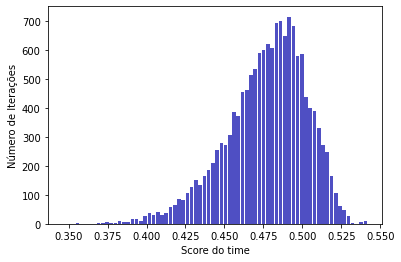

In [10]:
plt.hist(x=c, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
plt.xlabel('Score do time')
plt.ylabel('Número de Iterações')

Performance: score dos melhores times ao longo das iterações (convergência)

Text(0.5, 0, 'Aumento do Score')

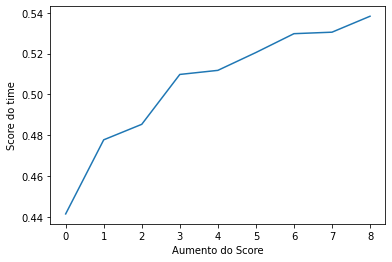

In [11]:
plot(a)
plt.ylabel('Score do time')
plt.xlabel('Aumento do Score')

O time escalado

In [12]:
time

,id,apelido,media,posicao,preco,pontos,jogos,minimo_para_valorizar,score_atleta
101,101,Walter,6.83,Goleiro,13.61,8.00,3,5.27,0.541513
125,125,Paulo Miranda,1.63,Zagueiro,3.00,3.60,3,1.78,0.507931
159,159,Mercado,4.17,Zagueiro,7.23,9.50,3,4.47,0.525976
132,132,Lucas Pires,8.17,Lateral,11.84,12.80,3,6.24,0.582794
106,106,Matheus Alexandre,3.17,Lateral,6.18,2.70,3,2.11,0.521252
150,150,Raniele,5.33,Meia,9.03,3.80,3,2.93,0.550128
98,98,Wellington Rato,3.53,Meia,8.96,0.00,3,1.85,0.512262
197,197,Rodrigo Fernández,1.83,Meia,4.91,-1.50,3,0.58,0.505180
44,44,Erison,8.80,Atacante,11.30,0.90,3,2.17,0.624067
117,117,Ademir,5.20,Atacante,11.38,2.60,3,3.14,0.528525
